# Data Model : Classification Model using Titanic Data 

#### Build XGBoost Model to Predict the Survival of a Titanic Passenger

`XGBoost : SKLearn API`

###  Organization of the Notebook

Read Titanic Data

Split Data : Train, Validation, Test 

Build Model using SKLearn API

Model using Default Parameters

Predict 

Performance Measure on Test Data

Plot Metrics

`SHAP Analysis` for `Model Explainability`

Cross Validation

Probability Calibration 

In [71]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import xgboost as xgb

In [4]:
try:
    from ipywidgets import interact, SelectMultiple
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False

In [5]:
%matplotlib inline

### Read Data

In [6]:
# import seaborn as sns
# train_df = sns.load_dataset('titanic')
# train_df = train_df.drop(['who','alive','alone'], axis=1)

In [7]:
# """CatBoost"""
# from catboost.datasets import titanic
# train_df, test_df = titanic()

In [8]:
# null_value_stats = train_df.isnull().sum(axis=0)
# null_value_stats[null_value_stats != 0]
# train_df.fillna(np.nan, inplace=True)
# test_df.fillna(np.nan, inplace=True)

In [9]:
# X = train_df.drop('Survived', axis=1)
# y = train_df.Survived

In [10]:
from ipynb.fs.full.example_titanicData_dataProcessing import *
train_df, test_df = train_test_ordinal

In [12]:
X = train_df.drop('Survived', axis=1)
y = train_df.Survived

#### Split Data

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
"""Setting the Seed"""
theSeed = 209

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.80, random_state=theSeed)
print(f'train data: {X_train.shape}')
print(f'valid data: {X_valid.shape}')

train data: (785, 16)
valid data: (197, 16)


In [16]:
#X_test = test_df
X_test = test_df.drop('Survived', axis=1)
y_test = test_df.Survived
print(f'test data : {X_test.shape}')

test data : (327, 16)


#### Setting Weight to the Data

In [17]:
# scale_pos_weight = np.random.rand(X_train.shape[0], )

### Train Model

#### Model With Default Parameters

In [18]:
# param_grid = {
#     'n_estimators': 100,
#     'max_depth': 5,
#     'learning_rate': 0.1,
#     'objective': 'binary',
#     'booster': 'gbtree', 
#     'tree_method': 'auto',
#     'n_jobs': 2,
#     'gamma': 1.0,
#     'min_child_weight': 0.001, 
#     'max_delta_step': 0.0,
#     'subsample': 1.0, 
#     'colsample_bytree': 1.0, 
#     'colsample_bylevel': 1.0,
#     'colsample_bynode': 1.0,
#     'reg_alpha': 0.0, 
#     'reg_lambda': 0.0,
#     'scale_pos_weight': 1.0,
#     'random_state': None,
#     'verbose': False}

In [19]:
model = xgb.XGBClassifier(
    #use_label_encoder=False,
    n_estimators=100,
    max_depth=5, 
    learning_rate=0.1, 
    objective='binary:logistic',
    booster='gbtree', 
    tree_method='auto',
    eval_metric=['auc','logloss','aucpr'], 
    n_jobs=2,
    gamma=0,
    min_child_weight=0.001, 
    max_delta_step=0.0,
    subsample=1.0, 
    colsample_bytree=1.0, 
    colsample_bylevel=1.0,
    colsample_bynode=1.0,
    reg_alpha=0.0, 
    reg_lambda=0.0,
    scale_pos_weight=1.0,
    #verbose=0,
    random_state=None
)

In [20]:
fit = model.fit(
    X_train, y_train,
    sample_weight=None, 
    base_margin=None,
    eval_set=[(X_valid, y_valid)],
    #eval_metric=['auc','logloss','aucpr'], 
    early_stopping_rounds=None, 
    #verbose=False, 
    xgb_model=None, 
    sample_weight_eval_set=None, 
    #base_margin_eval_set=None, 
    feature_weights=None, 
    #callbacks=None
)

#### Model Evaluation

In [21]:
from sklearn import preprocessing 

In [22]:
auc = list(model.evals_result_.values())[0]['auc']
auc = np.array(auc)
print(f"Mean AUC : { round(auc.mean(),4)}")
loss = list(model.evals_result_.values())[0]['logloss']
loss = np.array(loss)
print(f"Mean Loss : { round(loss.mean(),4) }")
aucpr = list(model.evals_result_.values())[0]['aucpr']
aucpr = np.array(aucpr)
print(f"Mean Loss : { round(aucpr.mean(),4) }")

Mean AUC : 0.9792
Mean Loss : 0.204
Mean Loss : 0.9596


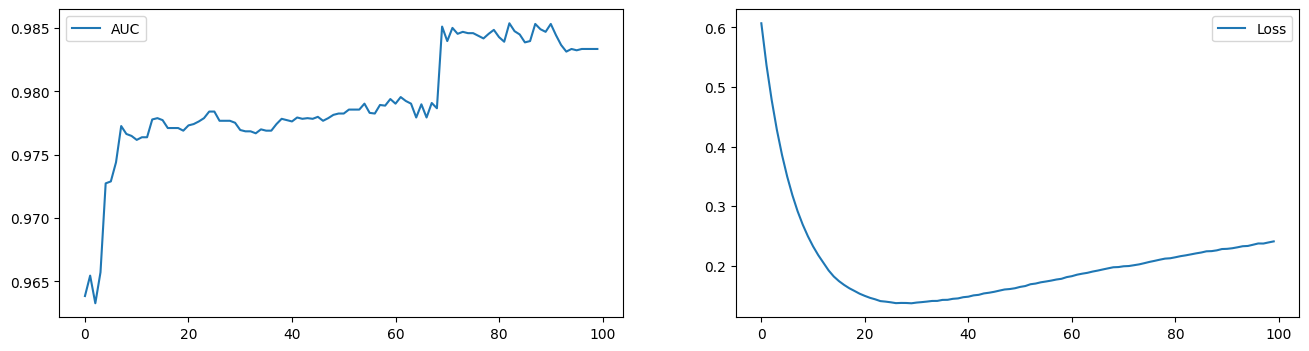

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
ax[0].plot(auc, label='AUC')
ax[1].plot(loss,label='Loss')

ax[0].legend()
ax[1].legend()
plt.show()

### Predict

In [24]:
y_pred = model.predict(
    X_test, 
    output_margin=False, 
    ntree_limit=None, 
    validate_features=True, 
    base_margin=None)

In [25]:
y_score = model.predict_proba(
    X_test, 
    ntree_limit=None, 
    validate_features=True, 
    base_margin=None)

### Performance Metrics on Test Data

In [26]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss

In [27]:
"""Accuracy Score"""
accuracy = accuracy_score(y_test, y_pred, sample_weight=None, normalize=True)
print( round(accuracy, 4))

0.9694


In [28]:
"""Balanced Accuracy Score"""
balanced_accuracy = balanced_accuracy_score(y_test, y_pred, sample_weight=None, adjusted=False)
print( round(balanced_accuracy, 4))

0.966


In [29]:
"""ROC Curve"""
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])

In [30]:
"""AUC"""
auc = auc(fpr, tpr)
print( round(auc, 4))

0.9867


In [31]:
"""Confusion Matrix"""
confusion_matrix(y_test, y_pred)

array([[199,   4],
       [  6, 118]])

In [32]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"TN:{tn}, FP:{fp}, FN:{fn}, TP:{tp}")

TN:199, FP:4, FN:6, TP:118


In [33]:
"""F1 Score"""
f1 = f1_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)
print( round(f1, 4))

0.9593


In [34]:
"""Log Loss"""
log_loss(y_test, y_score[:, 1], normalize=True, sample_weight=None, labels=[0,1])

0.18027999260064728

In [35]:
"""Precision, Recall, Fscore, Support"""
precision_recall_fscore_support(
    y_test, y_pred, 
    labels=[0,1], pos_label=1, 
    average=None, sample_weight=None
)

(array([0.97073171, 0.96721311]),
 array([0.98029557, 0.9516129 ]),
 array([0.9754902 , 0.95934959]),
 array([203, 124]))

In [36]:
precision = precision_score(
    y_test, y_pred, 
    labels=[0,1], pos_label=1, 
    average='binary', sample_weight=None
)
print( round(precision, 4))

0.9672


In [37]:
recall = recall_score(
    y_test, y_pred, 
    labels=[0,1], pos_label=1, 
    average='binary', sample_weight=None
)
print( round(recall, 4))

0.9516


### Performance Metric Plots

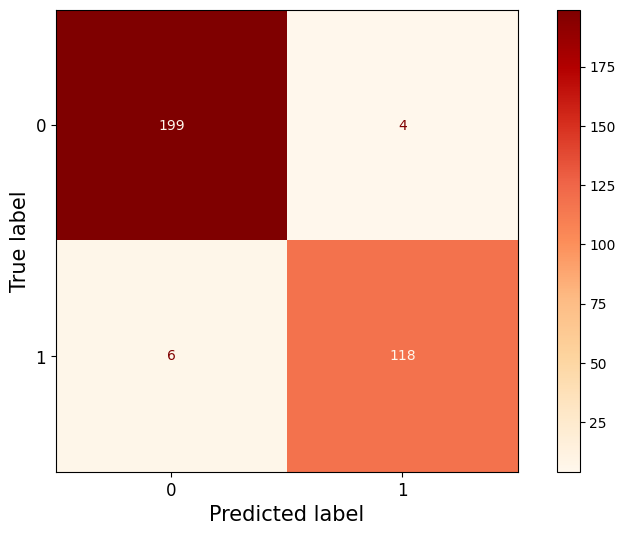

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,6))

ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels([0,1], fontsize=12)
ax.set_yticklabels([0,1], fontsize=12)
ax.set_xlabel("", fontsize=15)
ax.set_ylabel("", fontsize=15)


ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test, 
    labels=None, sample_weight=None, normalize=None, 
    display_labels=[0,1], 
    cmap='OrRd', 
    #color='w',
    ax=ax
)

plt.show()

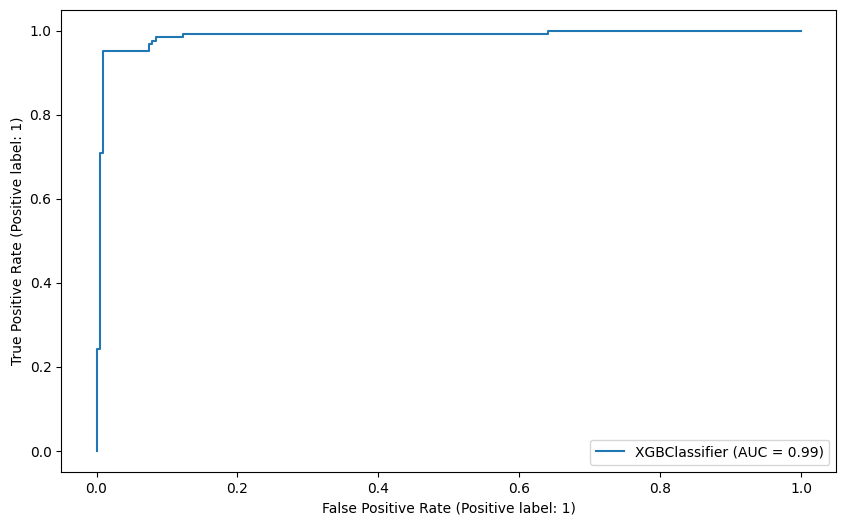

In [39]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(10,6))
RocCurveDisplay.from_estimator(model, X_test, y_test, sample_weight=None, ax=ax)

plt.show()

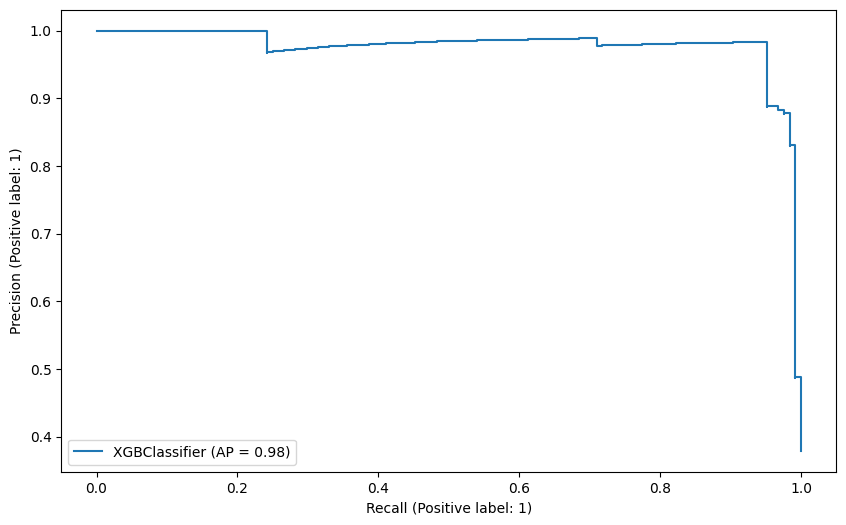

In [40]:
from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(figsize=(10,6))
PrecisionRecallDisplay.from_estimator(model, X_test, y_test, sample_weight=None, ax=ax)

plt.show()

#### Feature Importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

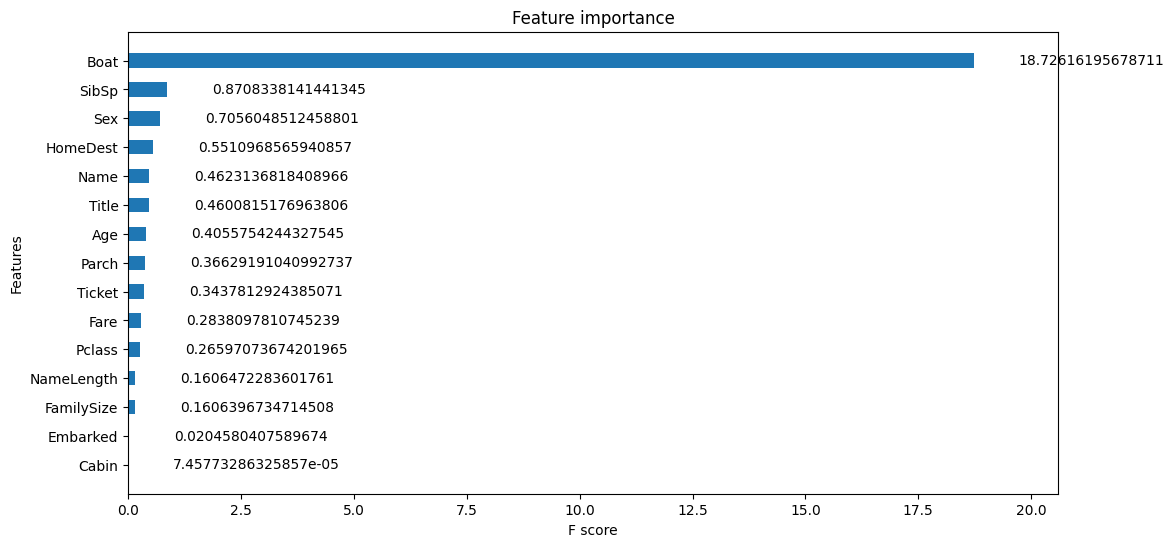

In [41]:
fig, ax = plt.subplots(figsize=(12,6))
xgb.plot_importance(fit, height=0.5, importance_type='gain', grid=False, ax=ax)

Trees

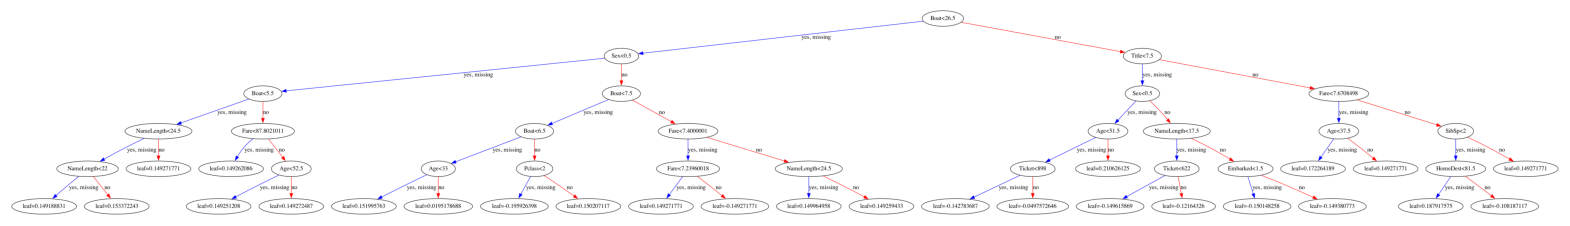

In [42]:
fig, ax = plt.subplots(figsize=(20,20))
xgb.plot_tree(fit, num_trees=4, rankdir='TB', ax=ax)
plt.show()

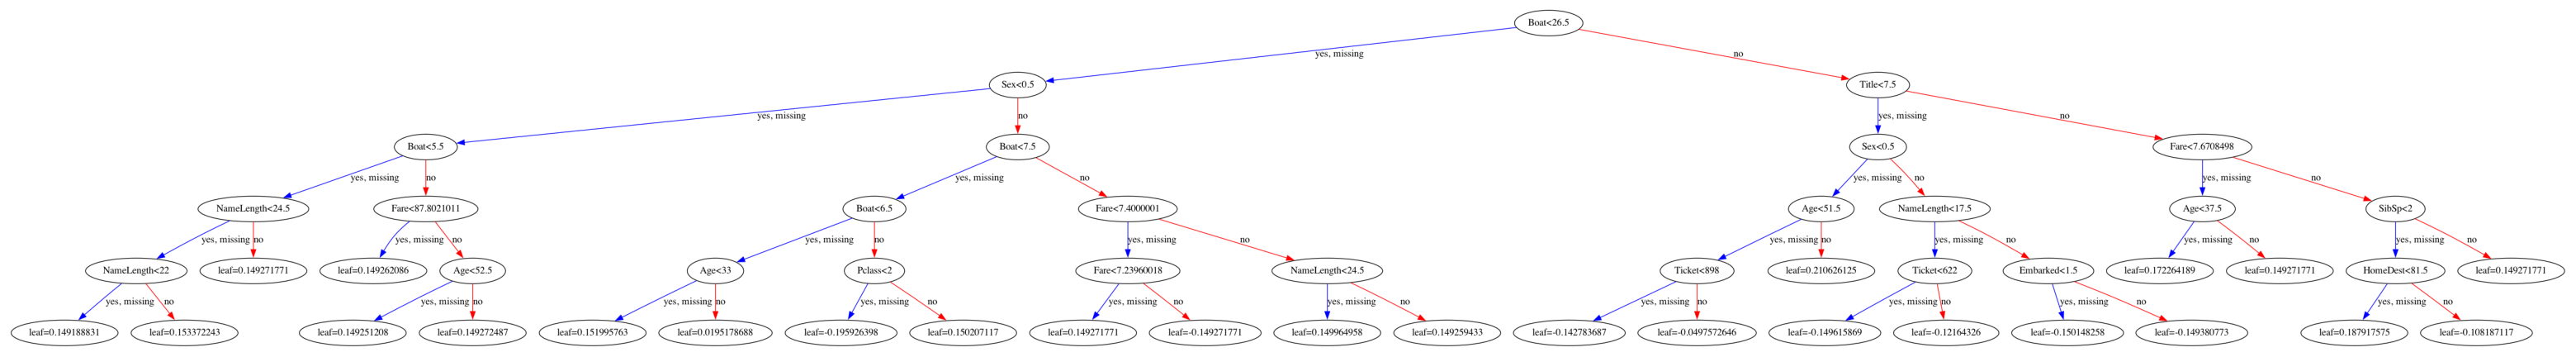

In [43]:
xgb.plot_tree(fit, num_trees=4, rankdir='TB')
fig = plt.gcf()
fig.set_size_inches(40,20)
plt.show()

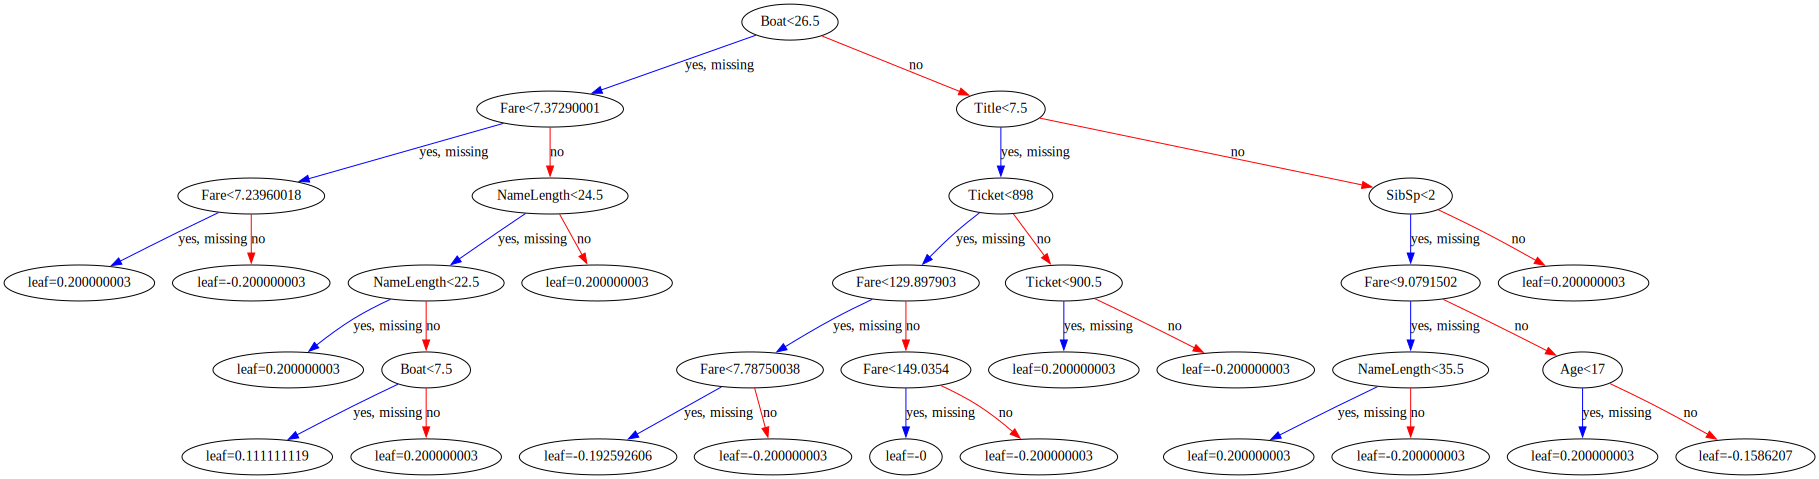

In [44]:
xgb.to_graphviz(fit, num_trees=0, rankdir='UT')

### SHAP Analysis

In [45]:
import shap
shap.initjs()

In [46]:
explainer = shap.Explainer(fit)
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [47]:
shap_values.shape

(785, 16)

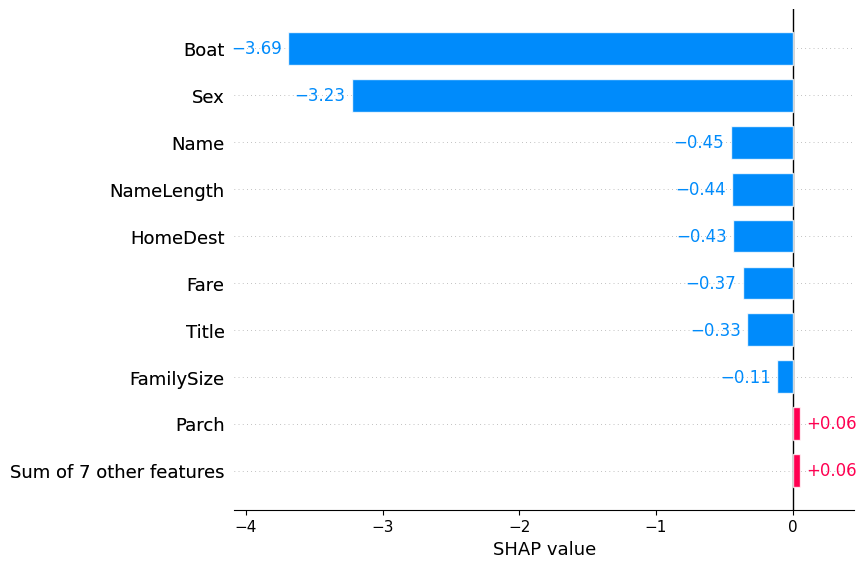

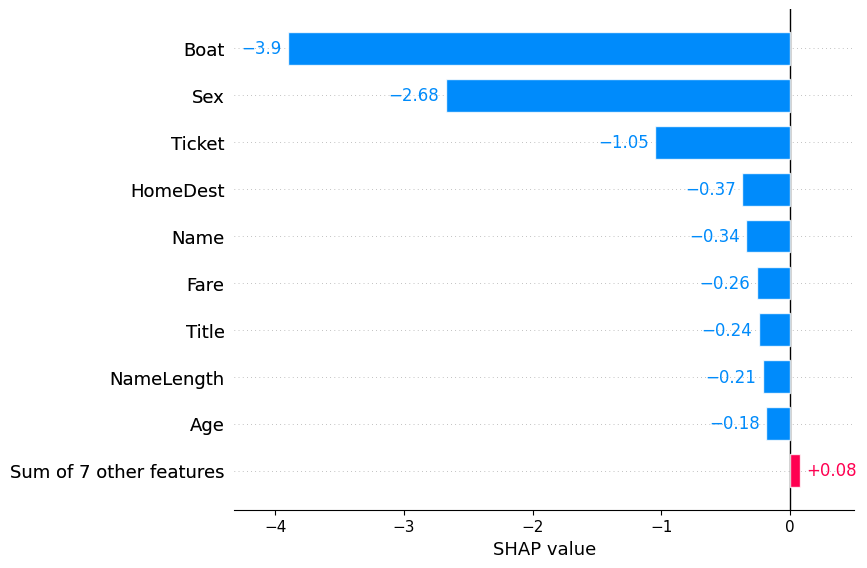

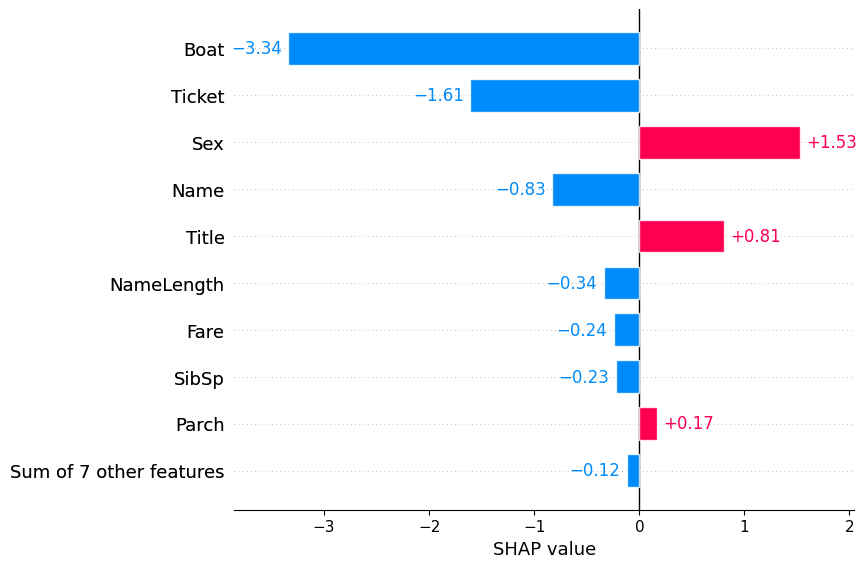

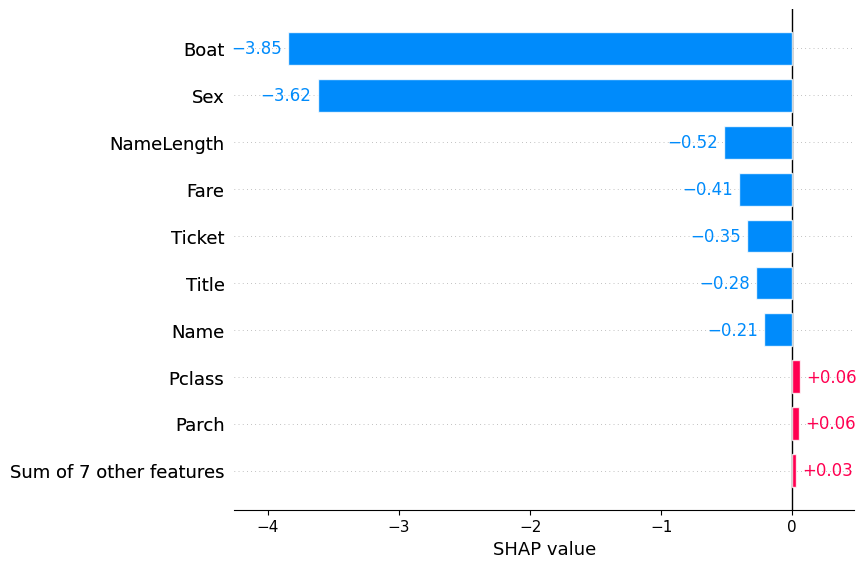

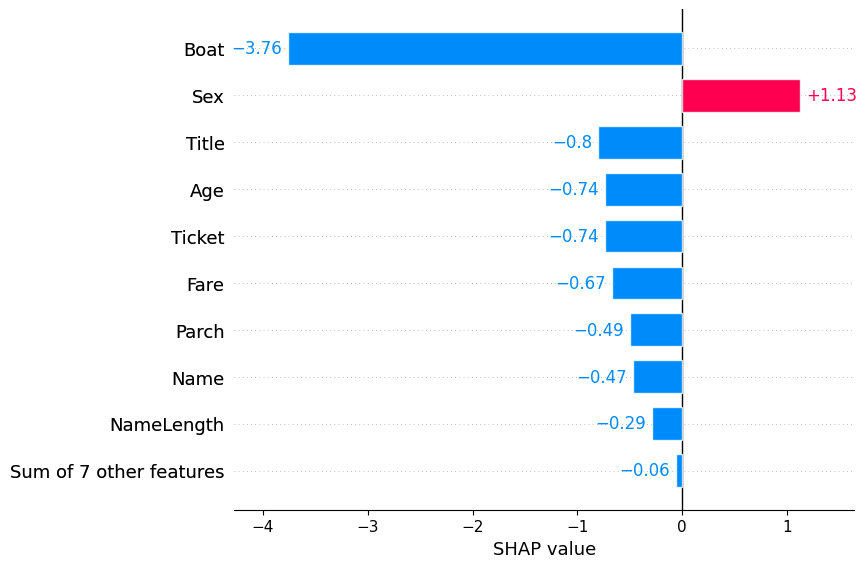

In [48]:
for i in range(5):
    shap.plots.bar(shap_values[i])

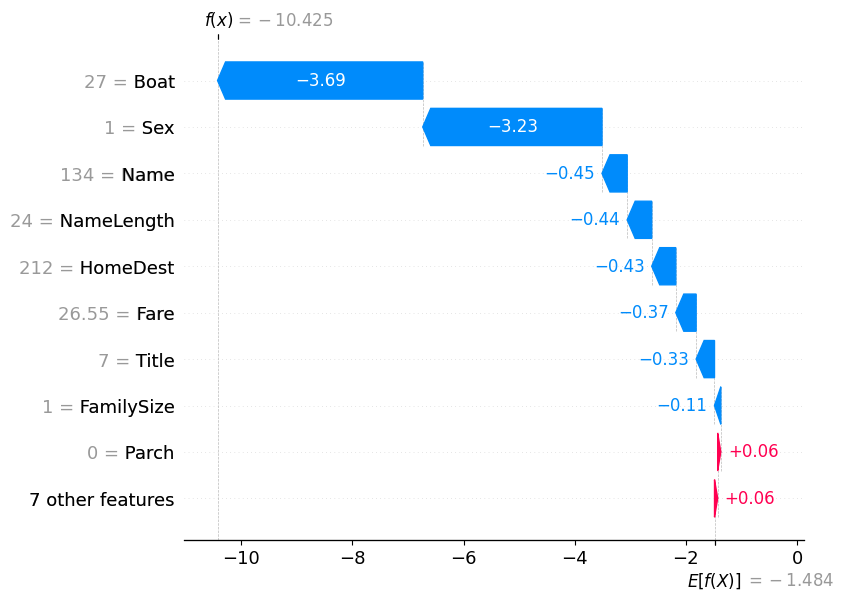

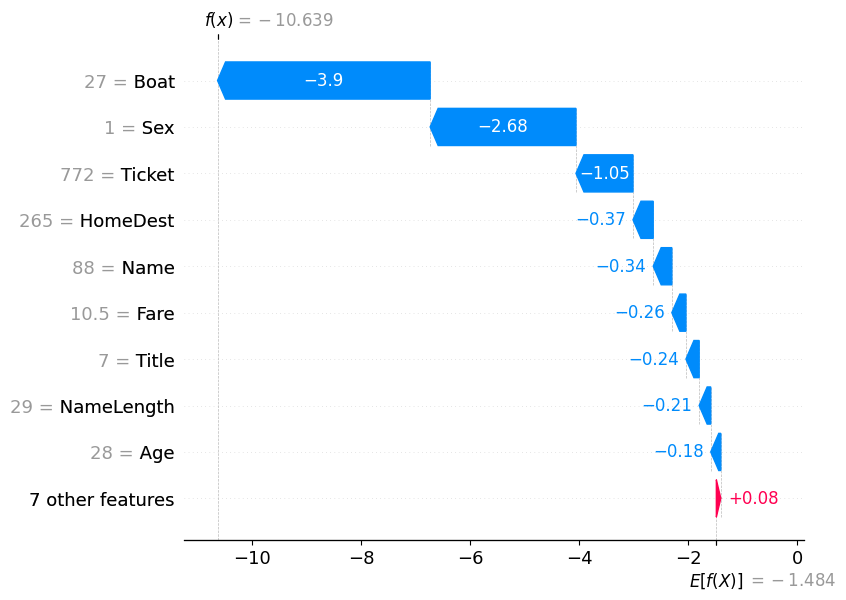

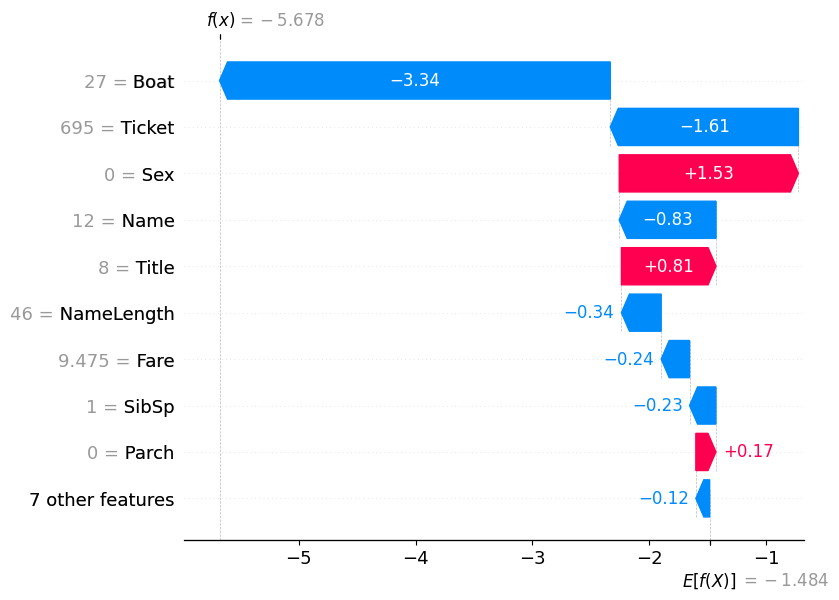

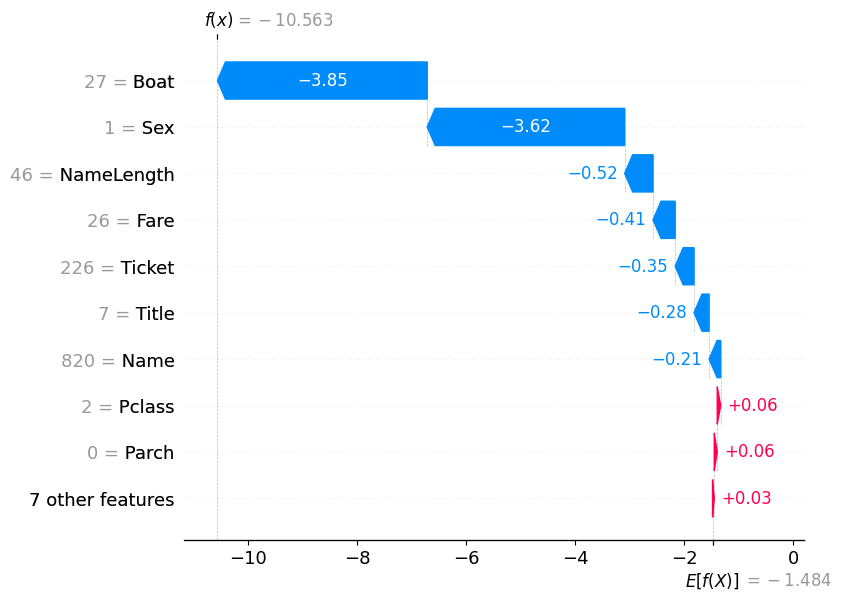

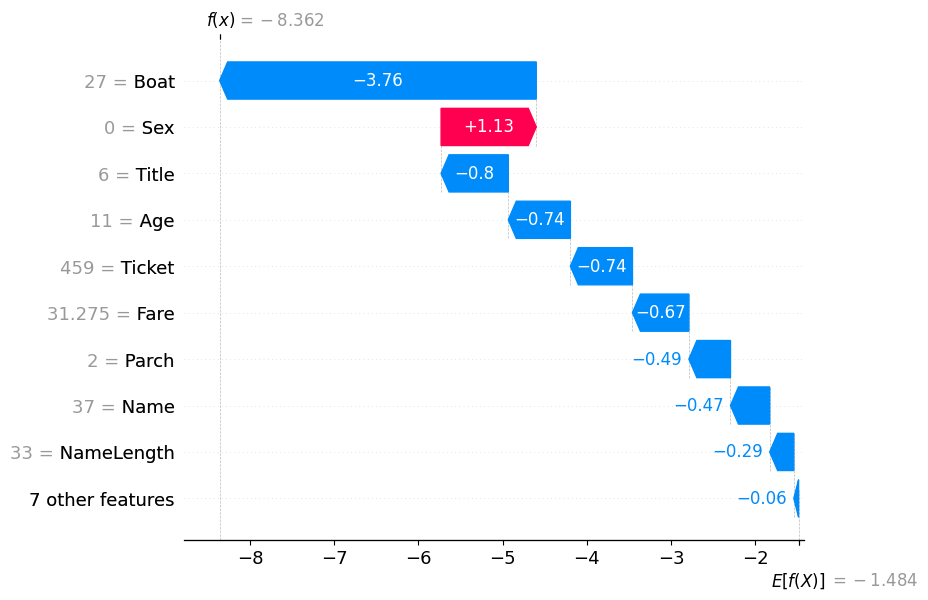

In [49]:
for i in range(5):
    shap.plots.waterfall(shap_values[i])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


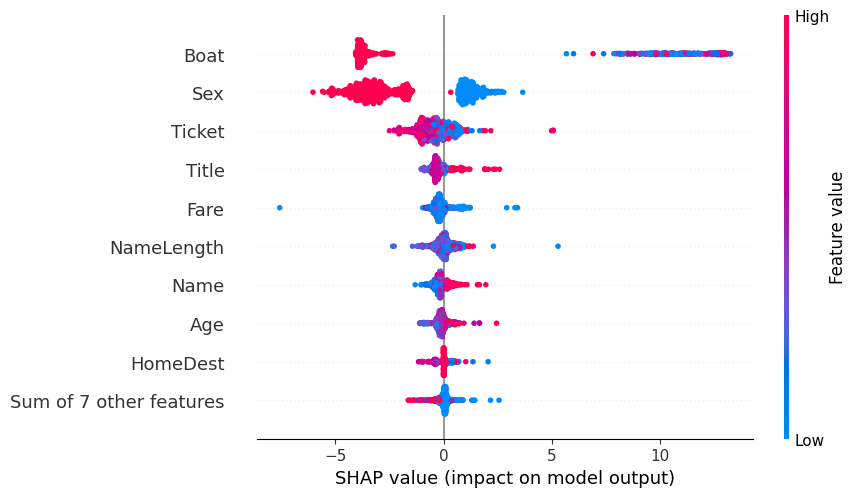

In [50]:
shap.plots.beeswarm(shap_values)

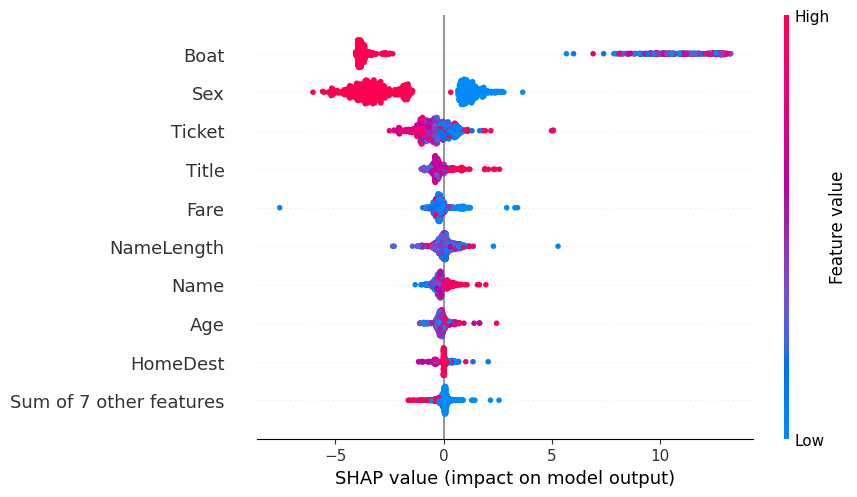

In [51]:
shap.plots.beeswarm(shap_values)

In [52]:
treeExplainer = shap.TreeExplainer(
    model, 
    data=None, 
    feature_perturbation= "tree_path_dependent", 
    model_output='raw')
shap_values = treeExplainer.shap_values(X_train)

Visualize the first Prediction's Explanation

In [53]:
shap.force_plot(treeExplainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

Visualize the first prediction's explanation

In [54]:
shap.force_plot(treeExplainer.expected_value, shap_values[:100,:], X_train.iloc[0:100,:])

SHAP Summary Plot

Summarize the effects of all the features

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


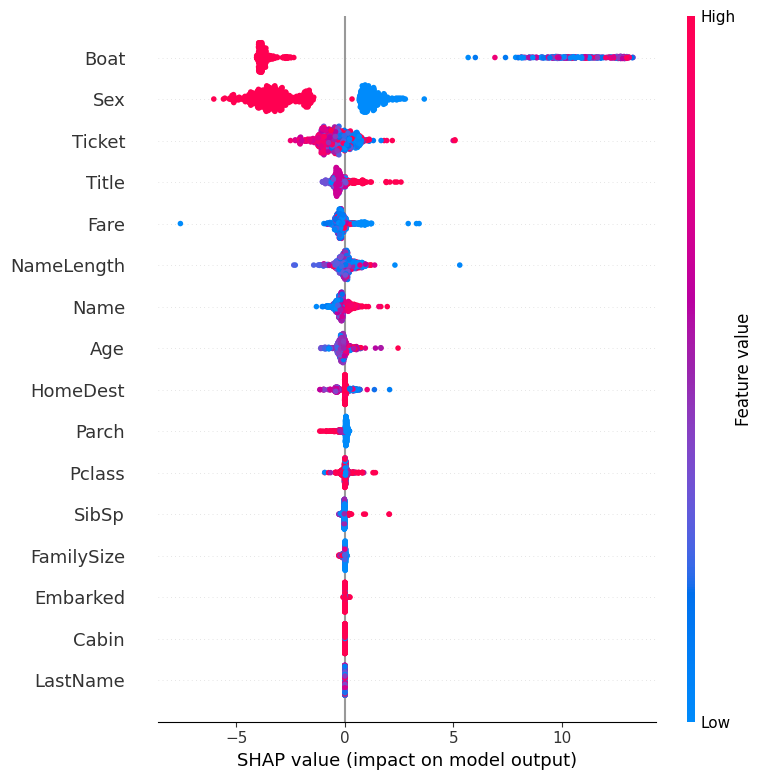

In [55]:
shap.summary_plot(shap_values, X_train)

SHAP Dependence Plot

Create a SHAP dependence plot to show the effect of a single feature across the whole dataset

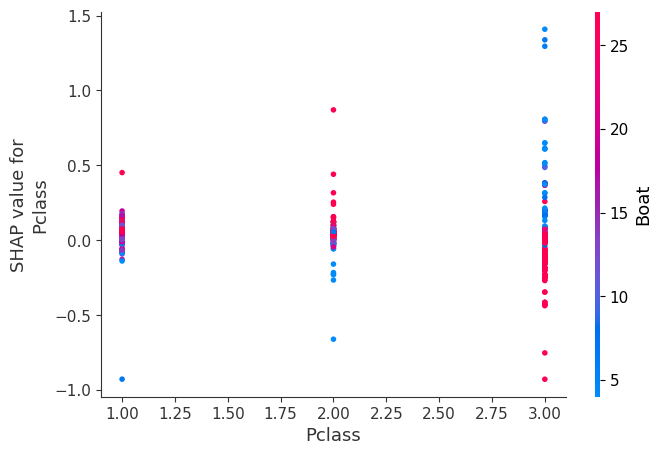

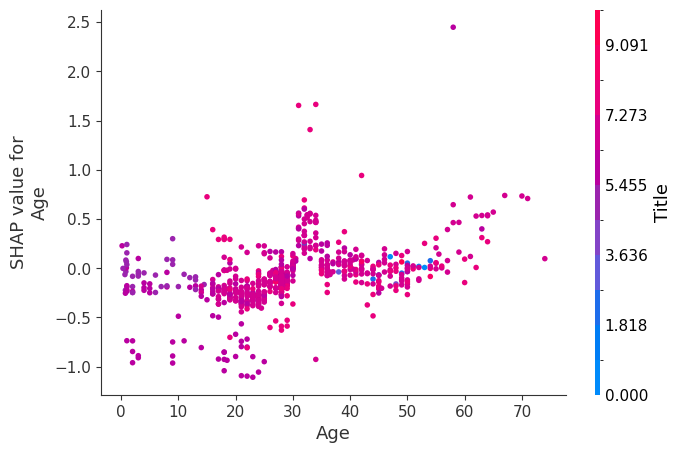

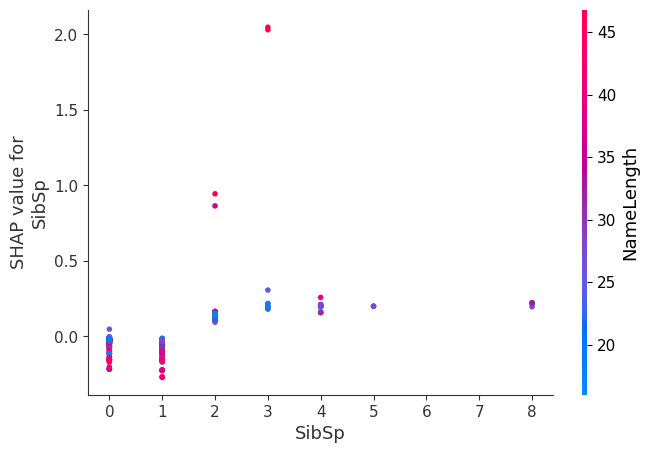

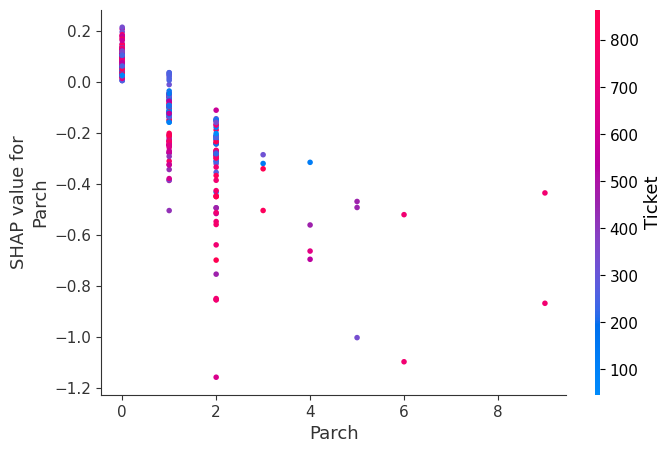

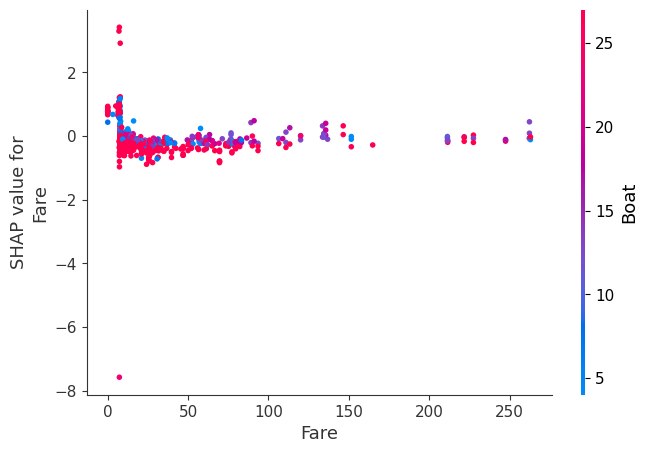

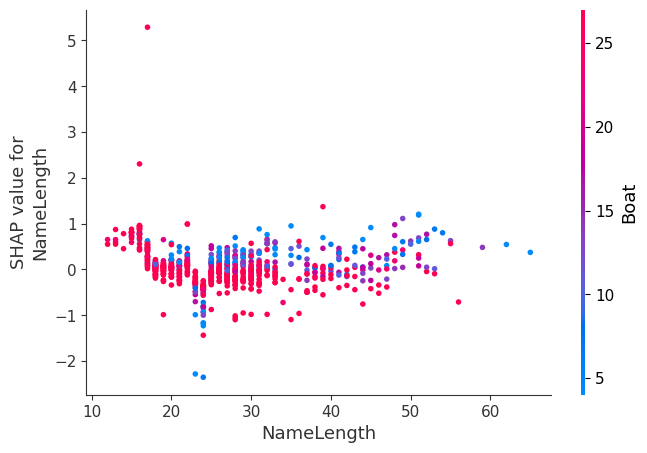

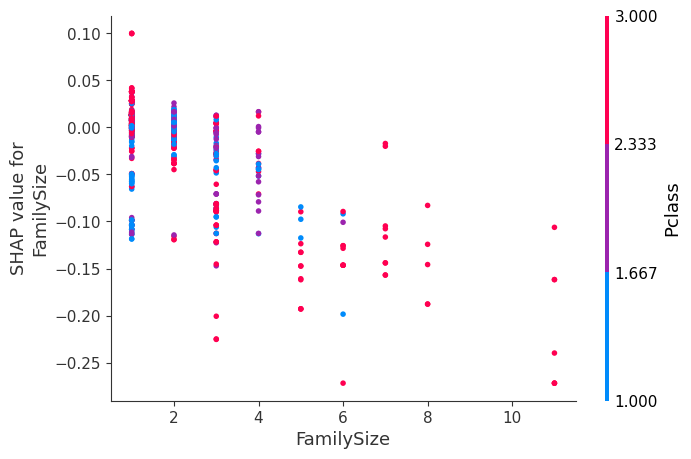

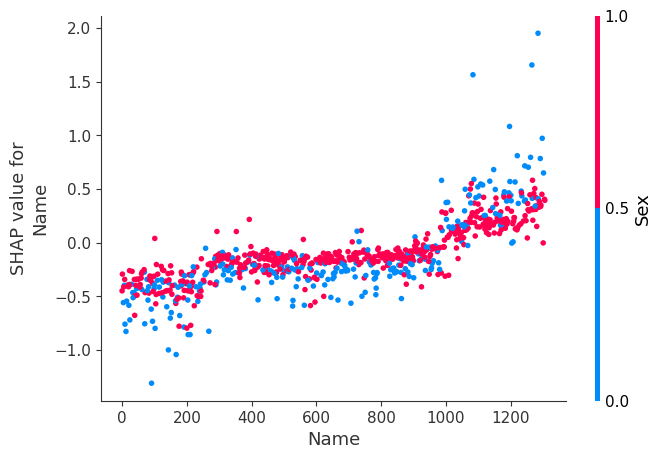

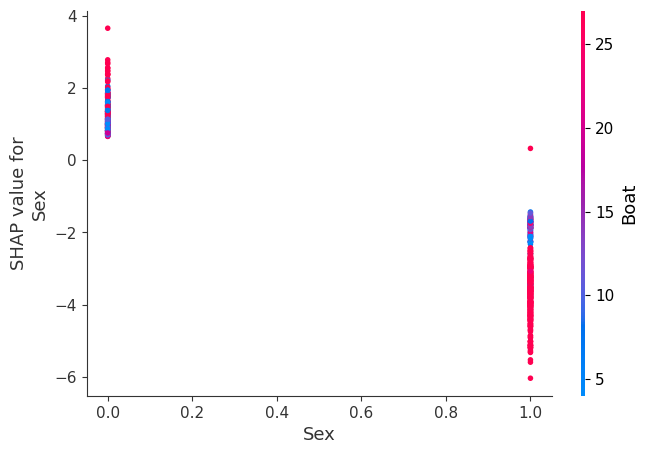

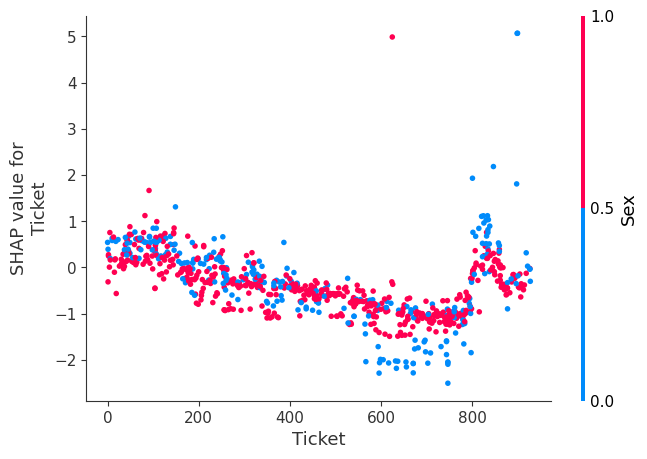

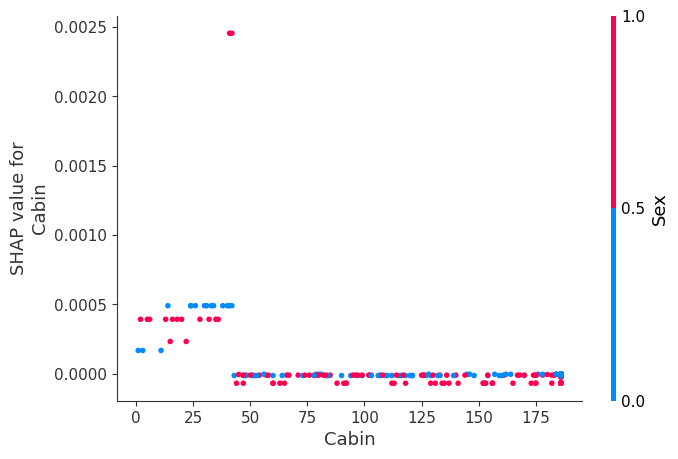

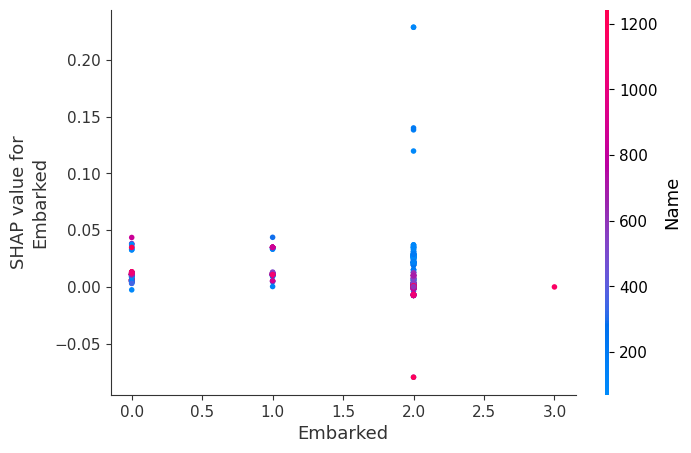

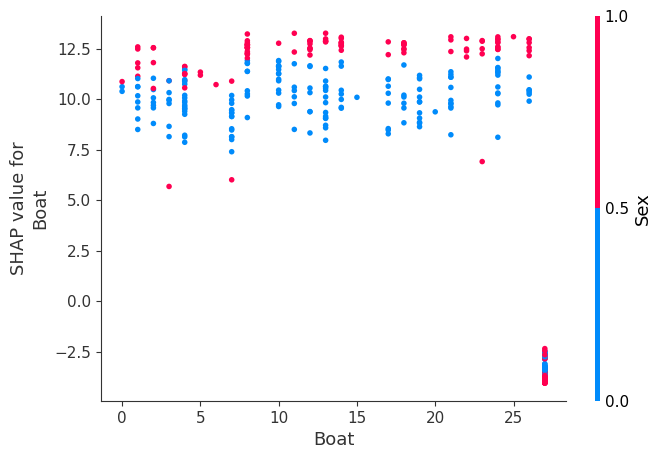

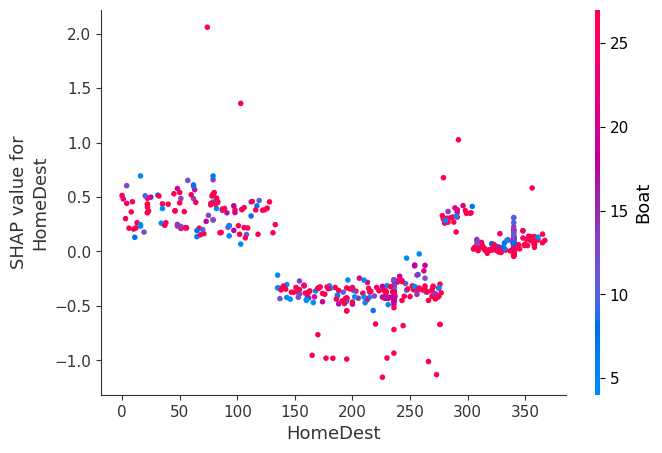

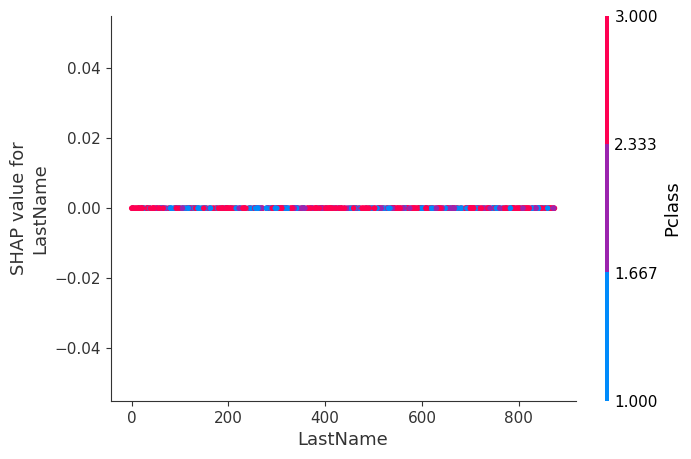

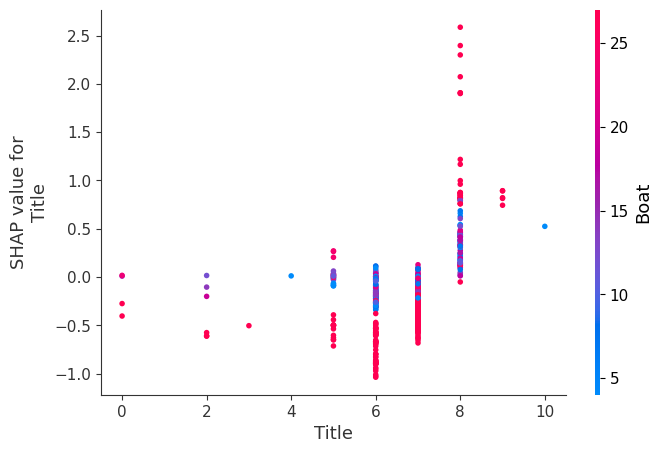

In [56]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)

### Cross-Validation 

In [57]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

#### Model with Default Parameters

In [58]:
cvmodel = xgb.XGBClassifier(
    #use_label_encoder=False,
    n_estimators=100,
    max_depth=5, 
    learning_rate=0.1, 
    objective='binary:logistic',
    booster='gbtree', 
    tree_method='auto',
    n_jobs=2,
    gamma=0,
    min_child_weight=0.001, 
    max_delta_step=0.0,
    subsample=1.0, 
    colsample_bytree=1.0, 
    colsample_bylevel=1.0,
    colsample_bynode=1.0,
    reg_alpha=0.0, 
    reg_lambda=0.0,
    scale_pos_weight=1.0,
    #verbose=0,
    random_state=None)

In [59]:
y_pred = cross_val_predict(cvmodel, X_train, y_train, cv=5)

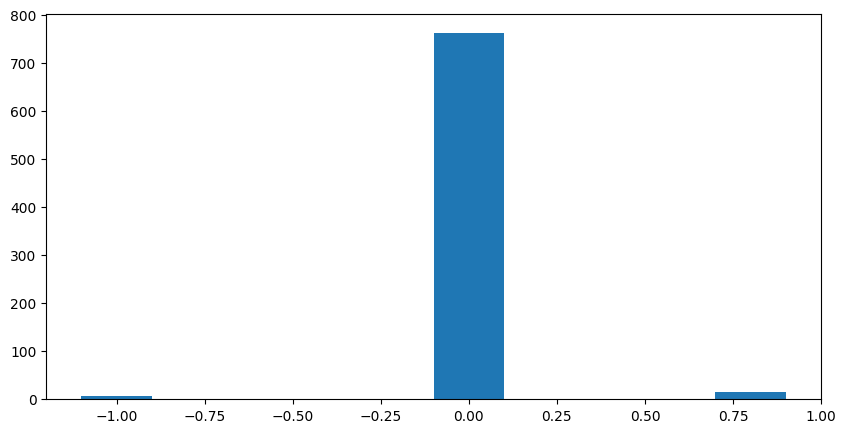

[0.0089172  0.         0.         0.         0.         0.97197452
 0.         0.         0.         0.01910828]


In [60]:
fig, ax = plt.subplots( figsize=(10,5) )

y_delta = y_train.to_numpy() - y_pred
n, bins, patches = ax.hist(y_delta, density=False, histtype='bar', rwidth=2.5, align='left', stacked=False)
plt.show()
print( n/len(y_pred) )

In [61]:
# fig, ax = plt.subplots( figsize=(12,7) )
# ax.scatter(y_train.to_numpy(), y_pred, edgecolors=(0, 0, 0))
# ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
# ax.set_xlabel('Observed')
# ax.set_ylabel('Predicted')
# plt.show()

In [62]:
scores = cross_val_score(cvmodel, X_train, y_train, scoring='accuracy', cv=5)
scores

array([0.98089172, 0.98089172, 0.96815287, 0.96815287, 0.96178344])

In [63]:
scores = cross_validate(cvmodel, X_train, y_train, scoring=['accuracy','roc_auc','f1'], cv=5)
scores

{'fit_time': array([0.09674096, 0.09363294, 0.09674406, 0.0959518 , 0.09261179]),
 'score_time': array([0.01046109, 0.00902295, 0.00936103, 0.00874019, 0.0087862 ]),
 'test_accuracy': array([0.98089172, 0.98089172, 0.96815287, 0.96815287, 0.96178344]),
 'test_roc_auc': array([0.98903509, 0.99631579, 0.9954386 , 0.98998607, 0.98659004]),
 'test_f1': array([0.97345133, 0.97345133, 0.95575221, 0.95575221, 0.94736842])}

### Probability Calibration

In [64]:
from sklearn.calibration import CalibratedClassifierCV

In [65]:
calibrated_model = CalibratedClassifierCV(estimator=model, method='sigmoid', cv='prefit')

In [66]:
calibrated_fit = calibrated_model.fit(X_test, y_test)

In [67]:
calibrated_y_pred  = calibrated_fit.predict(X_test)
calibrated_y_score = calibrated_fit.predict_proba(X_test)

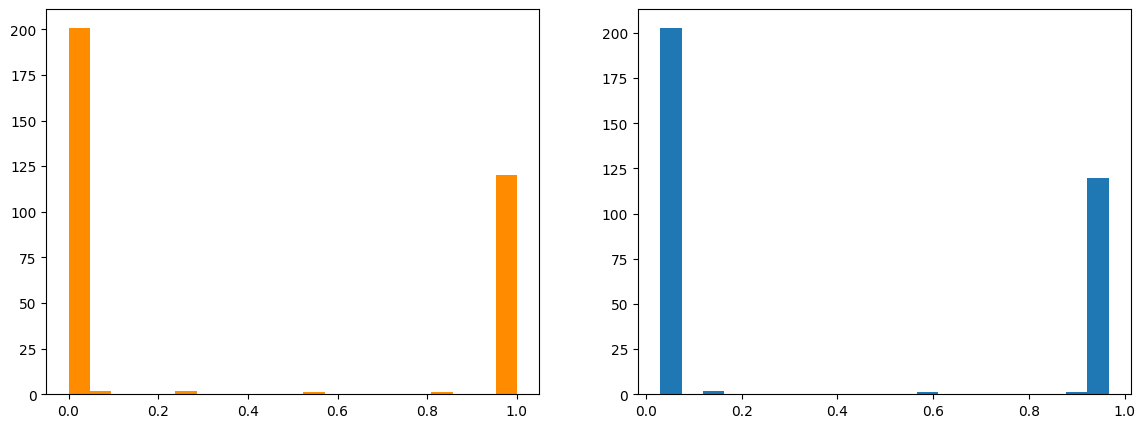

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (14,5))
ax[0].hist(y_score[:,1], bins=21, color='darkorange')
ax[1].hist(calibrated_y_score[:,1], bins=21)
plt.show()

#### Calibration Curve

In [69]:
from sklearn.calibration import calibration_curve

In [70]:
pdf = pd.DataFrame({'y_test': y_test, 'y_score': y_score[:,1]})
pdf #= pdf.sort_values(by='y_score', ascending=True)
pdf['pbin'] = pd.cut( pdf['y_score'], bins=10, labels=['G'+str(x) for x in range(10)])